In [49]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [50]:
# Core
import os, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# Vis
import matplotlib.pyplot as plt
# TorchVision
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import make_grid
# Utils
from tqdm import tqdm

# Repro
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [51]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.

**Explanation:**

- img / 2 + 0.5 undoes a simple normalization (when mean ≈ 0.5, std ≈ 0.5).

- numpy() converts the tensor to a NumPy array so that matplotlib can handle it.

- np.transpose(npimg, (1, 2, 0)) swaps axes from Channel-Height-Width (C,H,W) → Height-Width-Channel (H,W,C),
because PyTorch stores images channel-first, but matplotlib displays them channel-last.



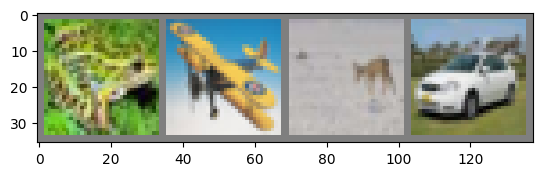

frog  plane deer  car  


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


# Utility function to display an image tensor
def imshow(img):
    # Unnormalize: reverse the normalization applied during preprocessing
    # (if images were normalized roughly to mean=0.5, std=0.5)
    img = img / 2 + 0.5     # bring values back to [0, 1]

    # Convert from PyTorch tensor (C, H, W) to NumPy array (H, W, C)
    npimg = img.numpy()

    # Transpose needed because matplotlib expects the last dimension to be color channels
    # PyTorch uses channel-first format: (C, H, W)
    # Matplotlib expects channel-last: (H, W, C)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# get some random training images
images, labels = next(iter(trainloader))
#images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).

self.conv1 = nn.Conv2d(3, 8, kernel_size=5)


| Argument       | Meaning                                      | In your case                                       |
| -------------- | -------------------------------------------- | -------------------------------------------------- |
| `in_channels`  | Number of input channels                     | **3** (R, G, B)                                    |
| `out_channels` | Number of filters / feature maps             | **8** — the network will learn 8 different filters |
| `kernel_size`  | Size of each filter (height × width)         | **5×5** pixels                                     |
| `stride`       | Step size when sliding the kernel            | Default = 1                                        |
| `padding`      | Number of zero-pixels added around the image | Default = 0  




- self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
- self.pool = nn.MaxPool2d(2, 2)
- self.conv2 = nn.Conv2d(8, 16, kernel_size=5)


| Layer   | Input Channels | Output Feature Maps | Comment                                                          |
| ------- | -------------- | ------------------- | ---------------------------------------------------------------- |
| `conv1` | 3 (RGB)        | 8                   | learns 8 feature types (edges, colors, etc.)                     |
| `pool`  | 8              | 8                   | pooling doesn’t change channel count — only reduces width/height |
| `conv2` | 8              | 16                  | takes those 8 maps as input, produces 16 new feature maps        |                                      |



In [74]:
import torch
import torch.nn as nn

x = torch.tensor([[1., 2., 3., 4., 5.]])          # [1, 5]
x = x.unsqueeze(0)                                # [B=1, C=1, L=5]

print(x.shape)
conv = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, bias=False)

# Задаем вручную фильтры
conv.weight.data = torch.tensor([
    [[2., 4., 6.]],    # filter 1
    [[-1., 1., 0.]]     # filter 2
])

y = conv(x)
print(y)


torch.Size([1, 1, 5])
tensor([[[28., 40., 52.],
         [ 1.,  1.,  1.]]], grad_fn=<ConvolutionBackward0>)


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        # MaxPool2d(2,2): looks at each 2×2 block in every feature map
        # and keeps only the maximum value.
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # -> 8x14x14
        x = self.pool(F.relu(self.conv2(x)))   # -> 16x5x5
        x = torch.flatten(x, 1)                # -> 16*5*5
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()



In [55]:
# Shape trace with a dummy batch (CIFAR-10 size)
B = 4
x = torch.randn(B, 3, 32, 32)

net = Net()

with torch.no_grad():
    print("input      :", x.shape)                  # [B, 3, 32, 32]
    x1 = net.pool(F.relu(net.conv1(x)))
    print("after conv1+pool:", x1.shape)            # [B, 8, 14, 14]
    x2 = net.pool(F.relu(net.conv2(x1)))
    print("after conv2+pool:", x2.shape)            # [B, 16, 5, 5]
    xf = torch.flatten(x2, 1)
    print("flatten    :", xf.shape)                 # [B, 400]
    o1 = F.relu(net.fc1(xf)); print("fc1:", o1.shape)   # [B, 120]
    o2 = F.relu(net.fc2(o1)); print("fc2:", o2.shape)   # [B, 84]
    o3 = net.fc3(o2);        print("fc3/logits:", o3.shape)  # [B, 10]


input      : torch.Size([4, 3, 32, 32])
after conv1+pool: torch.Size([4, 8, 14, 14])
after conv2+pool: torch.Size([4, 16, 5, 5])
flatten    : torch.Size([4, 400])
fc1: torch.Size([4, 120])
fc2: torch.Size([4, 84])
fc3/logits: torch.Size([4, 10])


In [56]:
for name, params in net.named_parameters():
    if 'conv' in name:
        print(name, params.size())

conv1.weight torch.Size([8, 3, 5, 5])
conv1.bias torch.Size([8])
conv2.weight torch.Size([16, 8, 5, 5])
conv2.bias torch.Size([16])


In [57]:
x1 = F.relu(net.conv1(images[0]))
x2 = F.relu(net.conv2(x1))

In [58]:
x1.shape, x2.shape

(torch.Size([8, 28, 28]), torch.Size([16, 24, 24]))

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [59]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(net.parameters(), lr=0.001)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [60]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.874
[1,  4000] loss: 1.633
[1,  6000] loss: 1.520
[1,  8000] loss: 1.464
[1, 10000] loss: 1.400
[1, 12000] loss: 1.380
[2,  2000] loss: 1.314
[2,  4000] loss: 1.307
[2,  6000] loss: 1.271
[2,  8000] loss: 1.230
[2, 10000] loss: 1.236
[2, 12000] loss: 1.243
Finished Training


Let's quickly save our trained model:



In [61]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



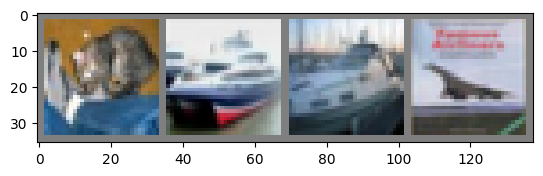

GroundTruth:  cat   ship  ship  plane


In [62]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [63]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [64]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [65]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [66]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [67]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.2 %
Accuracy for class: car   is 58.8 %
Accuracy for class: bird  is 42.9 %
Accuracy for class: cat   is 47.0 %
Accuracy for class: deer  is 44.1 %
Accuracy for class: dog   is 50.6 %
Accuracy for class: frog  is 58.2 %
Accuracy for class: horse is 72.3 %
Accuracy for class: ship  is 63.2 %
Accuracy for class: truck is 73.8 %


Aufgabe
1. Eiegene Bilddaten finden (oder gleiche auch gleiche wie bei der Aufgabe davor - langweilig)
2. Folgende Parameter zu testen in Hinblick auf besssere Accuracy und Reduzierung von Overfitting
  - Wieviele Conv2d layer überhaupt?
  - Anzahl der Kernels pro Layer (output channels)
  - Grösse der Kernels
  - Transforms nach wahl (minimum "to_tensor")
  - Wieviel dropout (in prozent z.B. 0.25) ist optimal gegen Overfitting)
  - Stride Grösse (1 und mehr)
  - padding = same
3. Bilder nicht all zu gross
4. Bestes model speichern
5. Inference mit einem Bild






In [68]:
# Data augmentation and normalization for training
# Just normalization for validation
# Diese Variante - wenn man die eigenen Bilder auf data folder von Colab legt mit zwei
# unter-ordnern train und val

# Normalize: image[channel] = (image[channel] - mean[channel]) / std[channel]


data_transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'data/mydata'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

FileNotFoundError: [Errno 2] No such file or directory: 'data/mydata/train'

In [70]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as dset
import torch

#dataset = dset.ImageFolder("data/mydata", transform=T.ToTensor())
#loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

mean = 0.0
std = 0.0
total = 0
for imgs, _ in trainloader:
    # imgs shape: [B, C, H, W]
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    total += batch_samples

mean /= total
std /= total
print(mean, std)


tensor([-0.0172, -0.0357, -0.1069]) tensor([0.4046, 0.3988, 0.4019])
